In [46]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score,recall_score
from sklearn.model_selection import GridSearchCV
import joblib
from torch.utils.data import DataLoader, TensorDataset
# Use below code to upload your kaggle.json to colab environment (you can download kaggle.json from your Profile->Account->API Token)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"worachotej","key":"6a42cc234064b82749f732e78beed52f"}'}

In [47]:
!mkdir -p ~/.kaggle  # Create the directory if not exists
!mv kaggle.json ~/.kaggle/  # Move the API key to the correct location
!chmod 600 ~/.kaggle/kaggle.json  # Secure the file

# Download the dataset
!kaggle datasets download -d datasetengineer/logistics-and-supply-chain-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/datasetengineer/logistics-and-supply-chain-dataset
License(s): CC0-1.0


In [48]:
df = pd.read_csv('dynamic_supply_chain_logistics_dataset.csv')
df.drop(columns=['timestamp', 'vehicle_gps_latitude', 'vehicle_gps_longitude'], inplace=True)
df.head()

,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [49]:
# Look if there are any duplicate rows in the dataset
df.loc[df.duplicated()]

,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation


In [50]:
# Check for null values
df.isna().sum()

,0
fuel_consumption_rate,0
eta_variation_hours,0
traffic_congestion_level,0
warehouse_inventory_level,0
loading_unloading_time,0
handling_equipment_availability,0
order_fulfillment_status,0
weather_condition_severity,0
port_congestion_level,0
shipping_costs,0


In [51]:
numerical_list = [x for x in df.columns if df[x].dtype in ('int64','float64')]
print(numerical_list)

['fuel_consumption_rate', 'eta_variation_hours', 'traffic_congestion_level', 'warehouse_inventory_level', 'loading_unloading_time', 'handling_equipment_availability', 'order_fulfillment_status', 'weather_condition_severity', 'port_congestion_level', 'shipping_costs', 'supplier_reliability_score', 'lead_time_days', 'historical_demand', 'iot_temperature', 'cargo_condition_status', 'route_risk_level', 'customs_clearance_time', 'driver_behavior_score', 'fatigue_monitoring_score', 'disruption_likelihood_score', 'delay_probability', 'delivery_time_deviation']


In [52]:
#Removal of outlier:

df1 = df.copy()

for i in numerical_list:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
# display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))
df = df1.copy()
df.head()


Inference:
Before removal of outliers, The dataset had 32065 samples.
After removal of outliers, The dataset now has 25245 samples.


,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [53]:
# Label encoding

label_encoder = LabelEncoder()
df['risk_classification'] = label_encoder.fit_transform(df['risk_classification'])

In [54]:
# target class are highly imbalanced
df['risk_classification'].value_counts()

,count
risk_classification,
0,20451
2,4277
1,517


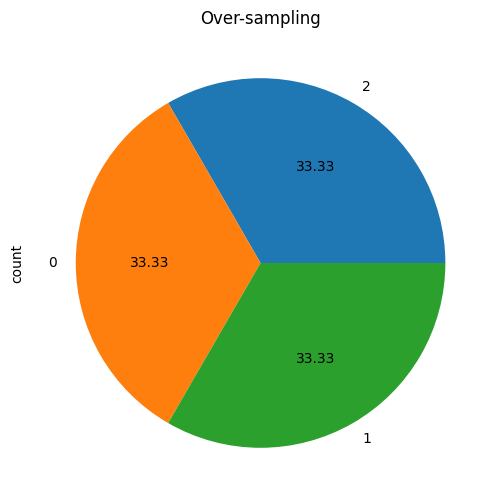

In [55]:
# solve imbalnce class

#Random Oversampling
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(sampling_strategy="not majority") # String
# X = df.drop(['risk_classification'], axis=1)
# Y = df['risk_classification']
# X, Y = ros.fit_resample(X, Y)

# ------------------------------------------------------------

# Apply SMOTE (Synthetic Minority Over-sampling)
from imblearn.over_sampling import SMOTE
X = df.drop(columns=["risk_classification"])  # Features
Y = df["risk_classification"]  # Target
smote = SMOTE(sampling_strategy="auto", random_state=42)
X, Y = smote.fit_resample(X, Y)

ax = Y.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [56]:
# after solve imbalnce class
Y.value_counts()

,count
risk_classification,
2,20451
0,20451
1,20451


In [57]:
# Split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 42)

#  Select Features Using Information Gain For Classification In ML

from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.03572476, 0.03286309, 0.0264211 , 0.02365959, 0.02880101,
       0.02965269, 0.03861242, 0.02840366, 0.03513281, 0.02091676,
       0.03120255, 0.03492473, 0.04906607, 0.03246656, 0.03746517,
       0.02841354, 0.02599664, 0.03713889, 0.03534024, 1.09861532,
       0.03249778, 0.03816256])

In [58]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

,0
disruption_likelihood_score,1.098615
historical_demand,0.049066
order_fulfillment_status,0.038612
delivery_time_deviation,0.038163
cargo_condition_status,0.037465
driver_behavior_score,0.037139
fuel_consumption_rate,0.035725
fatigue_monitoring_score,0.035340
port_congestion_level,0.035133
lead_time_days,0.034925


<Axes: >

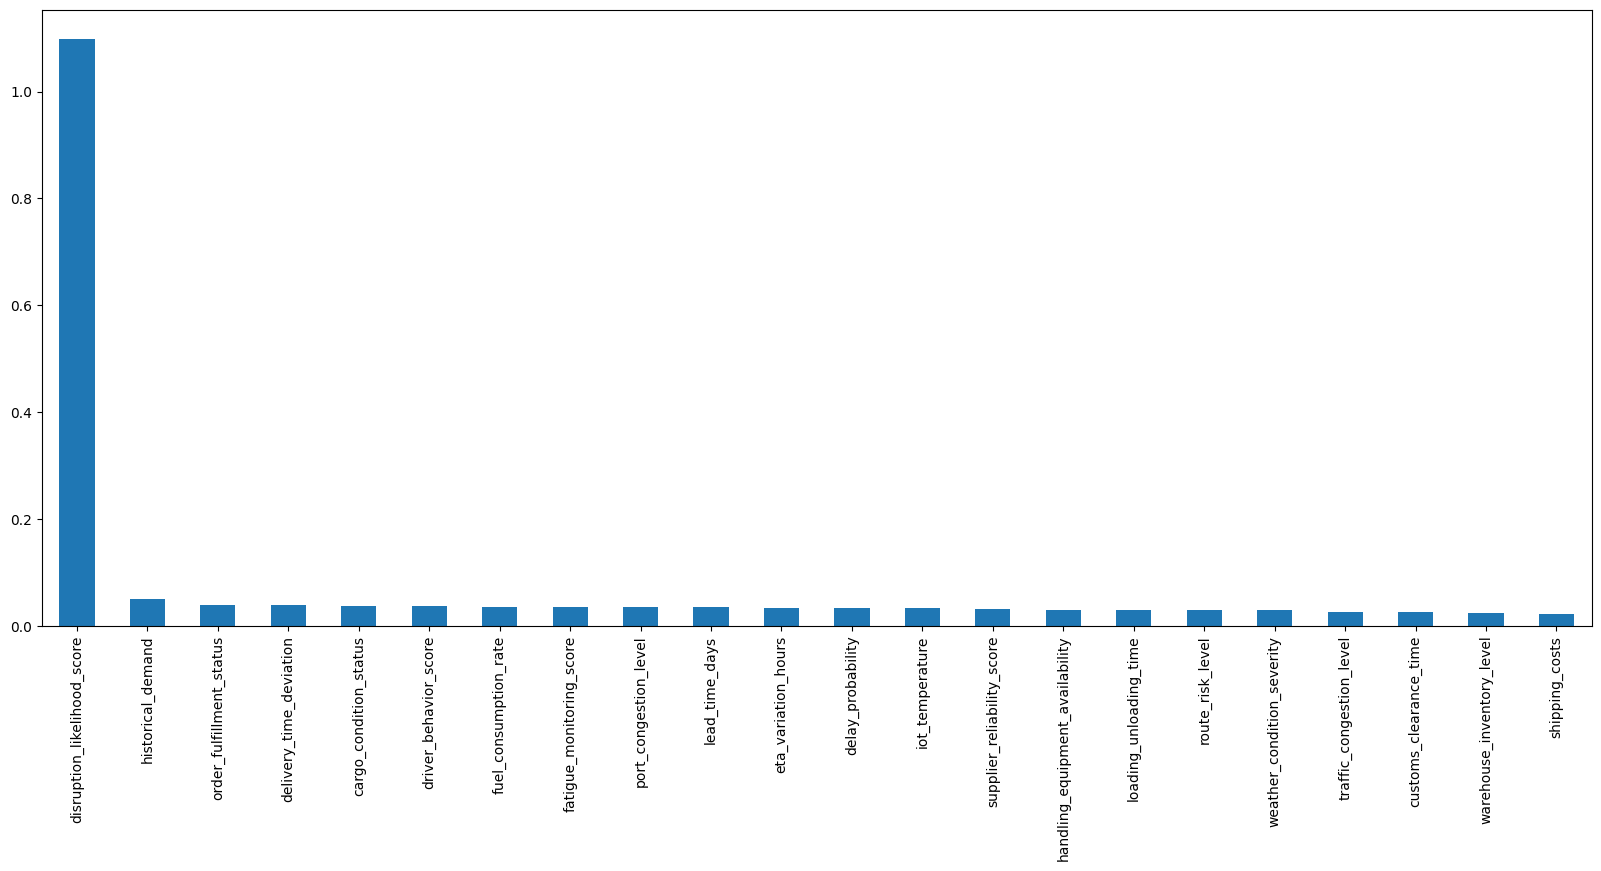

In [59]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [60]:
from sklearn.feature_selection import SelectKBest

#No we Will select the  top 5 important features
sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit(X_train, y_train)
selected_feature = X_train.columns[sel_five_cols.get_support()]
print(f"Top 5 Feature: {selected_feature}")

Top 5 Feature: Index(['order_fulfillment_status', 'historical_demand',
       'cargo_condition_status', 'disruption_likelihood_score',
       'delivery_time_deviation'],
      dtype='object')


In [61]:
X_train = X_train[selected_feature]
X_test = X_test[selected_feature]

X_train

,order_fulfillment_status,historical_demand,cargo_condition_status,disruption_likelihood_score,delivery_time_deviation
24481,0.882777,7205.246476,0.035134,1.000000,2.348545
58434,0.247370,7995.285807,0.594477,0.562096,8.768822
22492,0.756477,9932.483769,0.477842,0.776728,9.828261
39689,0.318124,9957.979009,0.194927,0.268893,7.516259
2888,0.916517,2104.904816,0.722561,0.999998,1.697481
...,...,...,...,...,...
54343,0.461909,9966.174332,0.076690,0.487871,6.648762
38158,0.930660,4601.759031,0.754161,0.292436,-0.352302
860,0.632656,8251.035573,0.217659,0.953890,3.389473
15795,0.853349,9967.005582,0.937680,0.999965,9.107156


In [62]:
# Transform data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
print(X_train_scaled)
X_test_scaled = scaler.transform(X_test)

[[0.88277692 0.71770158 0.03513418 0.9999999  0.36237853]
 [0.24736903 0.79750356 0.59447666 0.42515965 0.89740183]
 [0.7564762  0.99318018 0.47784152 0.70690859 0.98568843]
 ...
 [0.6326551  0.82333687 0.21765886 0.9394711  0.4491226 ]
 [0.85334865 0.99666723 0.93767998 0.99995409 0.9255963 ]
 [0.6650766  0.73330631 0.01289791 0.14487667 0.67038991]]


In [ ]:
import numpy as np

class SVM_Non_Linear_Scratch:
    def __init__(self, kernel='poly', C=1, degree=2, const=1, sigma=0.1, iterations=1000, learning_rate=0.001):
        self.X = None
        self.y = None
        self.alpha = None
        self.ones = None
        self.b = 0
        self.C = C
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.n_classes = None
        self.binary_classifiers = []

        if kernel == 'poly':
            self.kernel = self.polynomial_kernel
            self.degree = degree
            self.const = const
        elif kernel == 'rbf':
            self.kernel = self.gaussian_kernel
            self.sigma = sigma

    def polynomial_kernel(self, X, Z):
        # K(X, Z) = (c + X.Z)^degree
        return (self.const + X.dot(Z.T))**self.degree

    def gaussian_kernel(self, X, Z):
        # K(X, Z) = e^( -(1/ σ2) * ||X-Z||^2 )
        return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X[:, np.newaxis] - Z[np.newaxis, :], axis=2) ** 2)

    def decision_function(self, X, alpha, y, support_X, b):
        # ŷ = sign( (αi*yi).K(xi, xi) + b )
        return (alpha * y).dot(self.kernel(support_X, X)) + b

    def fit_binary(self, X, y):
        self.X = X
        self.y = y
        self.alpha = np.random.random(X.shape[0])
        self.ones = np.ones(X.shape[0])
        self.b = 0
        losses = []

        # (yi*yj) * K(xi, xj)
        kernel_mat = np.outer(y, y) * self.kernel(X, X)

        for i in range(self.iterations):
            # 1 – yk * ∑( αj*yj * K(xj, xk) )
            gradient = self.ones - kernel_mat.dot(self.alpha)
            # α = α + η*(1 – yk * ∑( αj*yj * K(xj, xk) )) update as per gradient descent rule
            self.alpha = self.alpha + self.learning_rate * gradient
            # 0 < α < C
            self.alpha[self.alpha > self.C] = self.C
            self.alpha[self.alpha < 0] = 0
            # ∑( αi – (1/2) * ∑i( ∑j( αi*αj * (yi*yj) * K(xi, xj) ) ) )
            loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * kernel_mat)
            losses.append(loss)

        # for bias, only consider α which 0 < α < C
        # b = avg(0≤αi≤C){ yi – ∑( αj*yj * K(xj, xi) ) }
        index = np.where((self.alpha > 0) & (self.alpha < self.C))[0]
        if len(index) > 0:
            b_ind = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))
            self.b = np.mean(b_ind)
        else:
            # If no support vectors found in the margin, use all points
            b_ind = y - (self.alpha * y).dot(self.kernel(X, X))
            self.b = np.mean(b_ind)

        return self.alpha, self.b, losses, X, y

    def fit(self, X, y):
        """
        Fit a multi-class SVM model using One-vs-Rest strategy
        """
        self.X = X
        unique_classes = np.unique(y)
        self.n_classes = len(unique_classes)

        if self.n_classes < 3:
            raise ValueError("This implementation requires at least 3 classes")

        self.binary_classifiers = []

        # Train one binary classifier for each class
        for i, current_class in enumerate(unique_classes):
            # Create binary labels (1 for current class, -1 for all other classes)
            binary_y = np.where(y == current_class, 1, -1)

            # Create a copy of the current instance to avoid parameter sharing
            binary_svm = SVM_Non_Linear_Scratch(
                kernel='poly' if hasattr(self, 'degree') else 'rbf',
                C=self.C,
                degree=self.degree if hasattr(self, 'degree') else 2,
                const=self.const if hasattr(self, 'const') else 1,
                sigma=self.sigma if hasattr(self, 'sigma') else 0.1,
                iterations=self.iterations,
                learning_rate=self.learning_rate
            )

            # Train the binary classifier
            alpha, b, losses, support_X, support_y = binary_svm.fit_binary(X, binary_y)

            # Store the trained parameters
            self.binary_classifiers.append({
                'class': current_class,
                'alpha': alpha.copy(),
                'b': b,
                'support_X': support_X,
                'support_y': support_y
            })

        return self

    def predict(self, X):
        """
        Predict class labels for samples in X
        """
        if len(self.binary_classifiers) == 0:
            raise ValueError("Model has not been fitted yet")

        # Calculate decision function values for each binary classifier
        decision_values = np.zeros((X.shape[0], self.n_classes))

        for i, classifier in enumerate(self.binary_classifiers):
            decision_values[:, i] = self.decision_function(
                X,
                classifier['alpha'],
                classifier['support_y'],
                classifier['support_X'],
                classifier['b']
            )

        # Return the class with the highest decision function value
        return np.array([self.binary_classifiers[i]['class'] for i in np.argmax(decision_values, axis=1)])

In [64]:
### Start Dimension Reduction for model (use PCA from scratch) ###

# First we find covariance manually or using numpy library

mean_vec = np.mean(X_train_scaled, axis=0)
cov_mat = (X_train_scaled - mean_vec).T.dot((X_train_scaled - mean_vec)) / (X_train_scaled.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 9.41031508e-02  1.01940841e-03 -2.35233453e-03 -2.61688590e-03
  -1.20137004e-04]
 [ 1.01940841e-03  1.18359964e-01  6.31972057e-04  1.43756233e-03
   1.37139398e-03]
 [-2.35233453e-03  6.31972057e-04  8.25960628e-02  2.37849882e-03
   5.57383025e-04]
 [-2.61688590e-03  1.43756233e-03  2.37849882e-03  1.45507034e-01
   2.19429920e-03]
 [-1.20137004e-04  1.37139398e-03  5.57383025e-04  2.19429920e-03
   9.67265606e-02]]


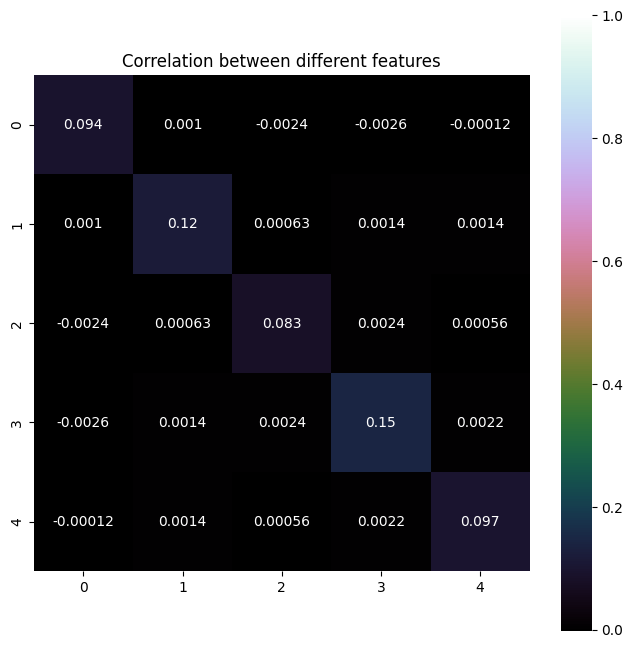

In [65]:
# Visualization of Covariance Matrix

plt.figure(figsize=(8,8))
sns.heatmap(cov_mat, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different features')
plt.show()

In [66]:
# Then we will calculate eigen value and eigen vector with built-in numpy function

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.05115797 -0.04614121 -0.18695236  0.97820471 -0.05846555]
 [ 0.05326799 -0.99573868  0.02011387 -0.04379482 -0.05783115]
 [ 0.04022994 -0.01184201 -0.98132505 -0.18368747  0.03874775]
 [ 0.99537314  0.05408075  0.02758899  0.05701588 -0.04791263]
 [ 0.04646768 -0.05753697  0.02973635  0.06485115  0.99470615]]

Eigenvalues 
[0.14591703 0.11841588 0.08205121 0.09433874 0.09656991]


In [67]:
# After that we will make pair of eigen vector and eigen value sorted by eigen value

eigen_pair = [[eig_vals[i] ,eig_vecs[:,i]] for i in range(len(eig_vals))]
eigen_pair.sort(key=lambda x : x[0], reverse=True)
eigen_pair

[[np.float64(0.14591703257280825),
  array([-0.05115797,  0.05326799,  0.04022994,  0.99537314,  0.04646768])],
 [np.float64(0.11841588414733992),
  array([-0.04614121, -0.99573868, -0.01184201,  0.05408075, -0.05753697])],
 [np.float64(0.09656990863394152),
  array([-0.05846555, -0.05783115,  0.03874775, -0.04791263,  0.99470615])],
 [np.float64(0.09433874001305413),
  array([ 0.97820471, -0.04379482, -0.18368747,  0.05701588,  0.06485115])],
 [np.float64(0.08205120687103323),
  array([-0.18695236,  0.02011387, -0.98132505,  0.02758899,  0.02973635])]]

In [68]:
# Calculate importance of vector

total = sum(eig_vals)
for i, val in enumerate(eigen_pair):
  print(f"Eigen Vector {i} : {(val[0]/total)*100}%")

Eigen Vector 0 : 27.15782532584014%
Eigen Vector 1 : 22.03935922198619%
Eigen Vector 2 : 17.973424103894878%
Eigen Vector 3 : 17.55816286529807%
Eigen Vector 4 : 15.271228482980723%


In [69]:
# Finally we select how many Component we want (For example we want 3 component left from the original)

def extractComponent(n_components, eigen_pair):
  total = np.sum([pair[0] for pair in eigen_pair])
  information_retain = np.sum([eigen_pair[i][0] for i in range(n_components)])
  print(f"{(information_retain / total) * 100:.2f}% of all information will be retain")
  len_max = len(eigen_pair[0][1])
  w = np.hstack(tuple([eigen_pair[i][1].reshape(len_max,1) for i in range(n_components)]))
  return w

w = extractComponent(4, eigen_pair)

84.73% of all information will be retain


In [70]:
w

array([[-0.05115797, -0.04614121, -0.05846555,  0.97820471],
       [ 0.05326799, -0.99573868, -0.05783115, -0.04379482],
       [ 0.04022994, -0.01184201,  0.03874775, -0.18368747],
       [ 0.99537314,  0.05408075, -0.04791263,  0.05701588],
       [ 0.04646768, -0.05753697,  0.99470615,  0.06485115]])

In [71]:
# After that we can apply matrix w to X_std to reduced dimension of all feature

X_train_PCA_Scratch = X_train_scaled.dot(w)
X_test_PCA_Scratch = X_test_scaled.dot(w)
X_train_PCA_Scratch

array([[ 1.00669483, -0.7225611 ,  0.22079135,  0.90616776],
       [ 0.51863496, -0.84119967,  0.83473213,  0.1802915 ],
       [ 0.78286894, -1.04799463,  0.86345123,  0.71294698],
       ...,
       [ 0.97624254, -0.82663121,  0.32556323,  0.62551799],
       [ 1.08549545, -1.04207641,  0.80158899,  0.73589999],
       [ 0.18091449, -0.7917588 ,  0.57910729,  0.66783268]])

In [73]:
# train model with reduced features (we use 5 feature previously)
# and save model as joblib file
import joblib
svm = SVM_Non_Linear_Scratch(kernel='rbf')

# train model
svm.fit(X_train_PCA_Scratch, y_train)

# Save the trained model
joblib.dump(svm, 'model_pca_svm.joblib')

['model_pca_svm.joblib']

In [74]:
# load model to use for evaluation
path_to_model = './model_pca_svm.joblib'
model_pca_svm_loaded = joblib.load(path_to_model)
y_pred = model_pca_svm_loaded.predict(X_test_PCA_Scratch)

In [75]:
# Begin Evaluation (classification)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Classification Report
print("classification report : ")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred )
print("Confusion Matrix : ")
print(cm)

classification report : 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5011
           1       0.98      1.00      0.99      5181
           2       0.98      0.97      0.98      5147

    accuracy                           0.99     15339
   macro avg       0.99      0.99      0.99     15339
weighted avg       0.99      0.99      0.99     15339

Confusion Matrix : 
[[4932    0   79]
 [   0 5178    3]
 [  13  120 5014]]


In [76]:
# Precision, Recall (Sensitivity), and F1-score for multiclass
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")  # Precision (average the results across all classes)
recall = recall_score(y_test, y_pred, average="macro")  # Sensitivity (average the results across all classes)
f1 = f1_score(y_test, y_pred, average="macro")  # F1-score (average the results across all classes)

# Compute Specificity for each class
specificity_list = []
for i in range(len(cm)):
    TP = cm[i, i]
    FN = sum(cm[i, :]) - TP
    FP = sum(cm[:, i]) - TP
    TN = np.sum(cm) - (TP + FN + FP)

    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    specificity_list.append(specificity)

specificity_macro = np.mean(specificity_list)  # Macro-averaged specificity

# Metrics (averages scores equally across all classes)
print(f'Accuracy : {accuracy:.4f}')
print(f'Precision (Macro): {precision:.4f}')
print(f'Sensitivity (Recall, Macro): {recall:.4f}')
print(f'Specificity (Macro): {specificity_macro:.4f}')
print(f'F1-Score (Macro): {f1:.4f}')

Accuracy : 0.9860
Precision (Macro): 0.9862
Sensitivity (Recall, Macro): 0.9859
Specificity (Macro): 0.9930
F1-Score (Macro): 0.9860


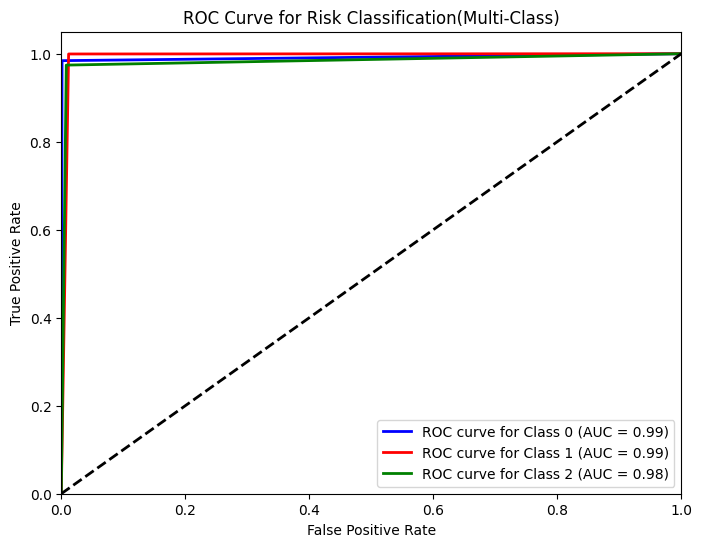

In [77]:
# Compute ROC curve and ROC AUC for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class ROC
# In the case of multiclass classification, a notion of TPR or FPR is obtained only after binarizing the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

n_classes = y_test_bin.shape[1]
# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve for Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Risk Classification(Multi-Class)')
plt.legend(loc="lower right")
plt.show()